In [ ]:
from scipy.io import wavfile

fs, signal = wavfile.read("/content/LJ050-0275.wav")

print("Sampling Frequency:", fs, "Hz")
print("Signal Shape:", signal.shape)


Sampling Frequency: 22050 Hz
Signal Shape: (201117,)


Original Sampling Frequency: 22050
Final Sampling Frequency Used: 16000


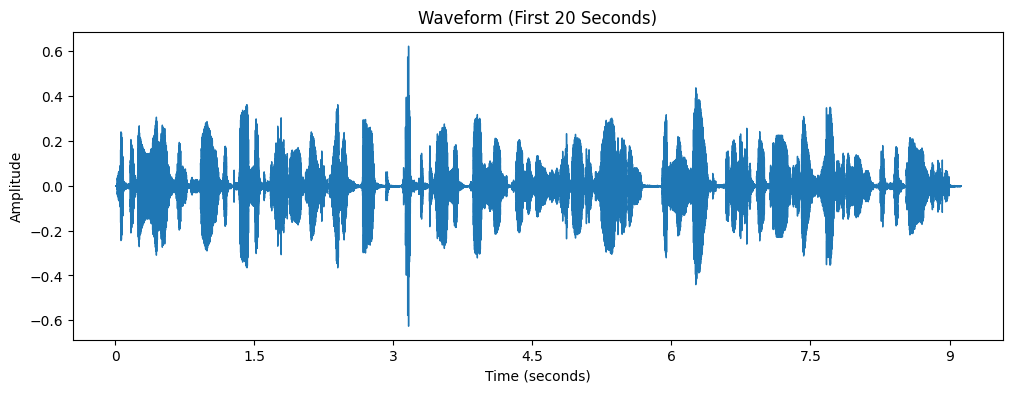

Number of Frames: 910


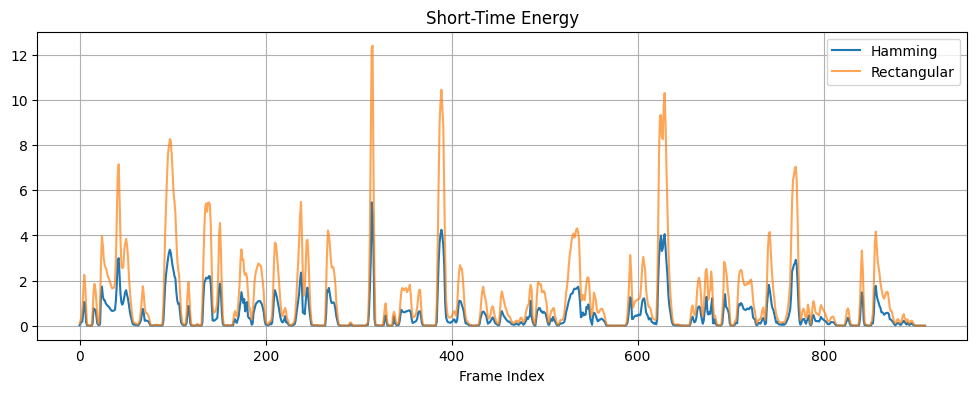

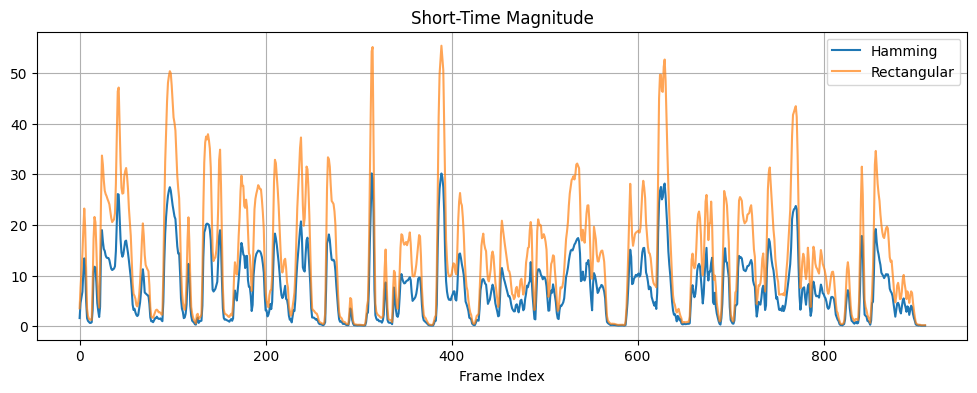

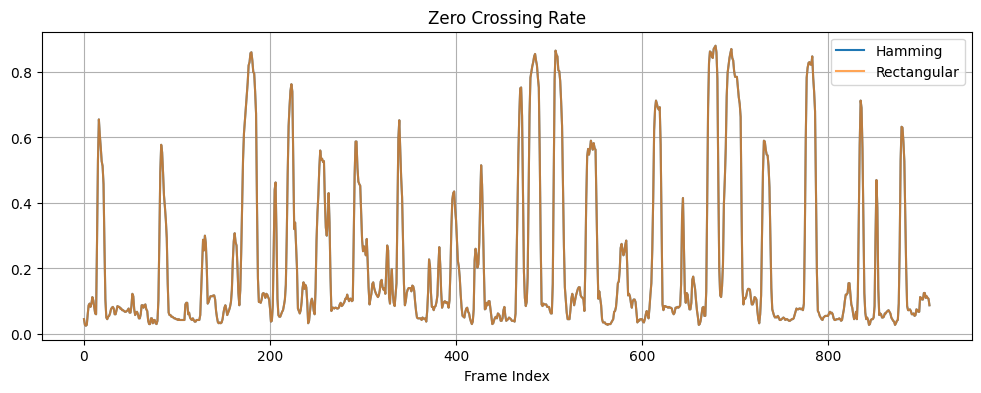

Total Voiced Frames Detected: 888
Estimated Pitch Frequency (Hz) - First 10 Frames:
[242.42424242 222.22222222 219.17808219 219.17808219 228.57142857
 228.57142857 225.35211268 202.53164557 186.04651163 228.57142857]


In [ ]:


import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load Speech File

file_path = "/content/LJ050-0275.wav"

# Load with original sampling rate
signal, fs = librosa.load(file_path, sr=None)
print("Original Sampling Frequency:", fs)

# Resample to 16 kHz
if fs != 16000:
    signal = librosa.resample(signal, orig_sr=fs, target_sr=16000)
    fs = 16000

print("Final Sampling Frequency Used:", fs)


# Task 1(a): Plot first 20 seconds

duration = 20 * fs
signal_20s = signal[:duration]

plt.figure(figsize=(12,4))
librosa.display.waveshow(signal_20s, sr=fs)
plt.title("Waveform (First 20 Seconds)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


# Frame Parameters

frame_length = int(0.025 * fs)   # 25 ms
frame_shift = int(0.01 * fs)     # 10 ms
N = len(signal_20s)


# Task 1(b): Number of frames

num_frames = int((N - frame_length) / frame_shift) + 1
print("Number of Frames:", num_frames)


# Task 1(c): Framing Function

def framing(signal, frame_length, frame_shift):
    frames = []
    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        frames.append(signal[start:end])
    return np.array(frames)

frames = framing(signal_20s, frame_length, frame_shift)


# Window Functions

hamming_window = np.hamming(frame_length)
rect_window = np.ones(frame_length)


# Feature Extraction Functions

def short_time_energy(frame):
    return np.sum(frame**2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame))

def autocorr(frame):
    ac = correlate(frame, frame, mode='full')
    return ac[len(ac)//2:]

def amdf(frame):
    N = len(frame)
    return np.array([np.sum(np.abs(frame[:N-l] - frame[l:])) for l in range(N)])

def amsdf(frame):
    N = len(frame)
    return np.array([np.sum((frame[:N-l] - frame[l:])**2) for l in range(N)])


# Task 1(d,e): Feature Extraction

def extract_features(frames, window):
    STE, STM, ZCR = [], [], []
    ACF, AMDF, AMSDF = [], [], []

    for frame in frames:
        frame = frame * window
        STE.append(short_time_energy(frame))
        STM.append(short_time_magnitude(frame))
        ZCR.append(zero_crossing_rate(frame))
        ACF.append(autocorr(frame))
        AMDF.append(amdf(frame))
        AMSDF.append(amsdf(frame))

    return np.array(STE), np.array(STM), np.array(ZCR), ACF, AMDF, AMSDF

# Hamming Window Features
STE_h, STM_h, ZCR_h, ACF_h, AMDF_h, AMSDF_h = extract_features(frames, hamming_window)

# Rectangular Window Features
STE_r, STM_r, ZCR_r, ACF_r, AMDF_r, AMSDF_r = extract_features(frames, rect_window)


# Task 1(f): Plot Features

features = [
    ("Short-Time Energy", STE_h, STE_r),
    ("Short-Time Magnitude", STM_h, STM_r),
    ("Zero Crossing Rate", ZCR_h, ZCR_r)
]

for title, ham, rect in features:
    plt.figure(figsize=(12,4))
    plt.plot(ham, label="Hamming")
    plt.plot(rect, label="Rectangular", alpha=0.7)
    plt.title(title)
    plt.xlabel("Frame Index")
    plt.legend()
    plt.grid()
    plt.show()


# Task 2: Periodicity Detection

voiced_frames = []

for i in range(len(ACF_h)):
    ac = ACF_h[i]

    r0 = ac[0]        # zero-lag (energy)
    ac[0] = 0         # remove zero-lag

    peak = np.max(ac) / r0   # normalized autocorrelation peak

    if peak > 0.3:    # standard voiced threshold
        voiced_frames.append(i)

print("Total Voiced Frames Detected:", len(voiced_frames))




# Task 3: Pitch Estimation
min_lag = int(fs / 400)
max_lag = int(fs / 60)
pitch_freqs = []

for i in voiced_frames:
    ac = ACF_h[i]
    ac[0] = 0

    search_region = ac[min_lag:max_lag]
    lag = np.argmax(search_region) + min_lag

    pitch_freqs.append(fs / lag)

pitch_freqs = np.array(pitch_freqs)

print("Estimated Pitch Frequency (Hz) - First 10 Frames:")
print(pitch_freqs[:10])



If frame has:
• Strong autocorrelation peak (periodic)
→ Voiced
Else
→ Unvoiced

other graphs

In [1]:
from scipy.io import wavfile

fs, signal = wavfile.read("/content/LJ050-0275.wav")

print("Sampling Frequency:", fs, "Hz")
print("Signal Shape:", signal.shape)


Sampling Frequency: 22050 Hz
Signal Shape: (201117,)


Original Sampling Frequency: 22050
Signal Shape: (201117,)
Final Sampling Frequency Used: 16000


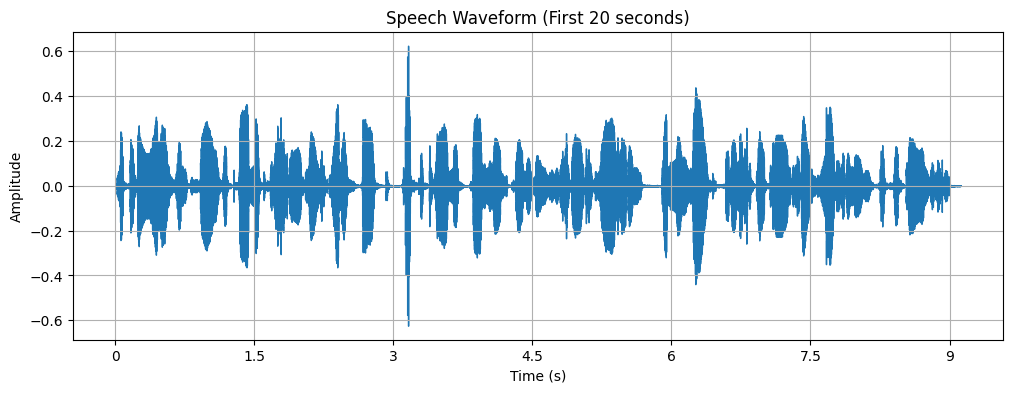

Number of Frames: 910


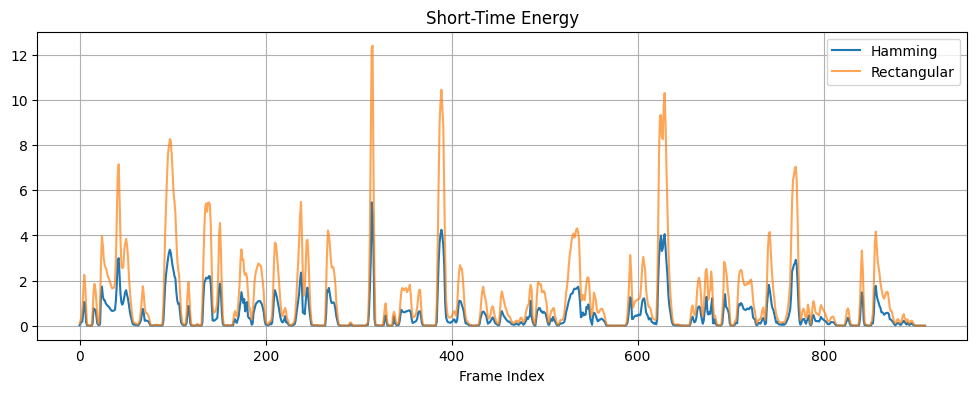

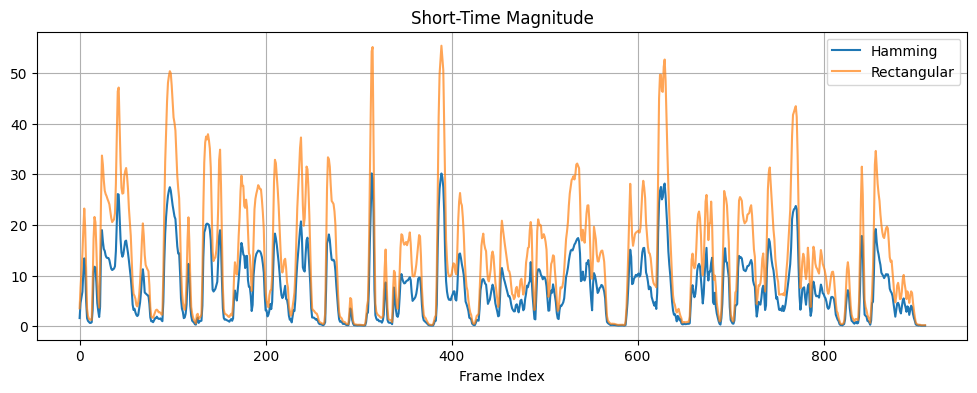

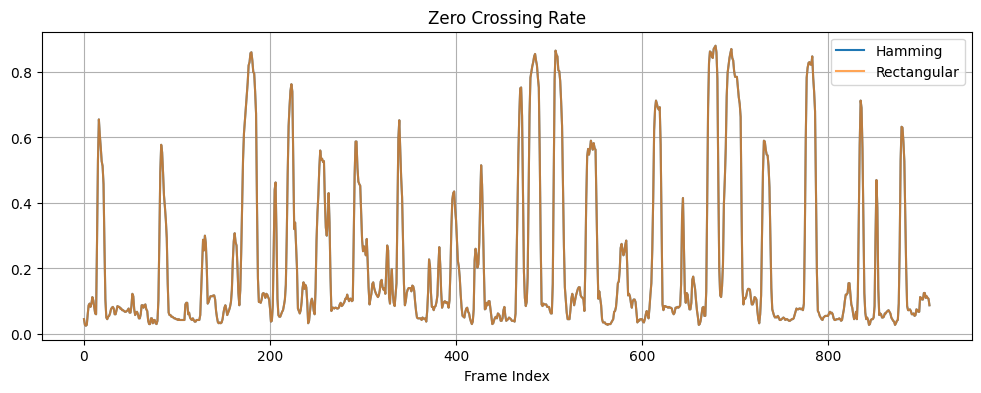

Voiced Frames (ACF): 695
Voiced Frames (AMDF): 835
Voiced Frames (AMSDF): 881
First 10 Pitch Values (Hz): [242.42424242 222.22222222 219.17808219 219.17808219 228.57142857
 228.57142857 225.35211268 202.53164557 186.04651163 228.57142857]


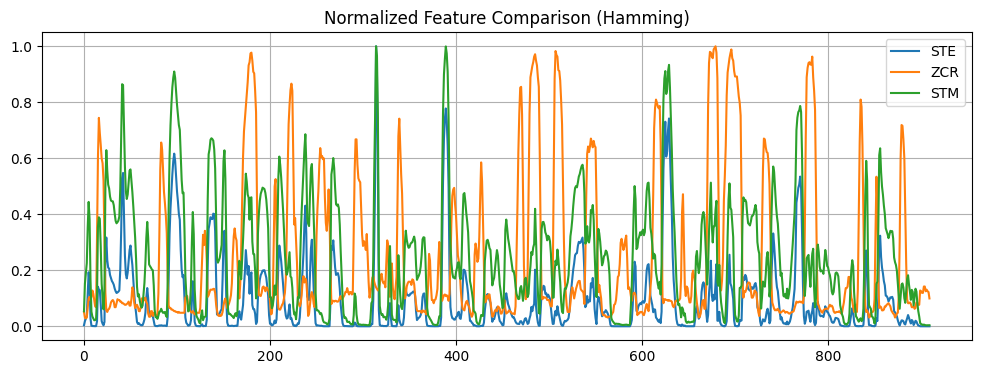

In [2]:

# SPEECH PROCESSING LAB ASSIGNMENT–4 (FINAL & COMPLETE)


import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.io import wavfile





fs_raw, sig_raw = wavfile.read("/content/LJ050-0275.wav")
print("Original Sampling Frequency:", fs_raw)
print("Signal Shape:", sig_raw.shape)





signal, fs = librosa.load("/content/LJ050-0275.wav", sr=None)

if fs != 16000:
    signal = librosa.resample(signal, orig_sr=fs, target_sr=16000)
    fs = 16000

print("Final Sampling Frequency Used:", fs)


#  TASK-1(a): WAVEFORM (FIRST 20 SECONDS)


signal_20s = signal[:20*fs]

plt.figure(figsize=(12,4))
librosa.display.waveshow(signal_20s, sr=fs)
plt.title("Speech Waveform (First 20 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


#  TASK-1(b,c): FRAMING


frame_length = int(0.025 * fs)
frame_shift  = int(0.01  * fs)

N = len(signal_20s)
num_frames = int((N - frame_length) / frame_shift) + 1
print("Number of Frames:", num_frames)

frames = np.array([
    signal_20s[i*frame_shift : i*frame_shift + frame_length]
    for i in range(num_frames)
])


#  WINDOW FUNCTIONS


hamming = np.hamming(frame_length)
rect    = np.ones(frame_length)


# FEATURE FUNCTIONS


def STE(x): return np.sum(x**2)
def STM(x): return np.sum(np.abs(x))
def ZCR(x): return np.sum(np.abs(np.diff(np.sign(x)))) / (2*len(x))

def ACF(x):
    r = correlate(x, x, mode='full')
    return r[len(r)//2:]

def AMDF(x):
    N = len(x)
    return np.array([np.sum(np.abs(x[:N-k] - x[k:])) for k in range(N)])

def AMSDF(x):
    N = len(x)
    return np.array([np.sum((x[:N-k] - x[k:])**2) for k in range(N)])


# TASK-1(d,e): FEATURE EXTRACTION


def extract(frames, window):
    ste, stm, zcr, acf, amdf, amsdf = [], [], [], [], [], []
    for f in frames:
        fw = f * window
        ste.append(STE(fw))
        stm.append(STM(fw))
        zcr.append(ZCR(fw))
        acf.append(ACF(fw))
        amdf.append(AMDF(fw))
        amsdf.append(AMSDF(fw))
    return np.array(ste), np.array(stm), np.array(zcr), acf, amdf, amsdf

STE_h, STM_h, ZCR_h, ACF_h, AMDF_h, AMSDF_h = extract(frames, hamming)
STE_r, STM_r, ZCR_r, ACF_r, AMDF_r, AMSDF_r = extract(frames, rect)


# TASK-1(f): SEPARATE PLOTS (HAMMING vs RECTANGULAR)


def plot_compare(y1, y2, title):
    plt.figure(figsize=(12,4))
    plt.plot(y1, label="Hamming")
    plt.plot(y2, label="Rectangular", alpha=0.7)
    plt.title(title)
    plt.xlabel("Frame Index")
    plt.legend()
    plt.grid()
    plt.show()

plot_compare(STE_h, STE_r, "Short-Time Energy")
plot_compare(STM_h, STM_r, "Short-Time Magnitude")
plot_compare(ZCR_h, ZCR_r, "Zero Crossing Rate")


# TASK-2: PERIODICITY DETECTION (ACF + AMDF + AMSDF)


voiced_acf, voiced_amdf, voiced_amsdf = [], [], []

min_lag = int(fs / 400)
max_lag = int(fs / 60)

for i in range(num_frames):
    # ---- ACF ----
    ac = ACF_h[i].copy()
    r0 = ac[0]
    ac[0] = 0
    if np.max(ac[min_lag:max_lag]) / r0 > 0.3:
        voiced_acf.append(i)

    # ---- AMDF ----
    d = AMDF_h[i]
    if np.min(d[min_lag:max_lag]) < 0.6 * np.mean(d):
        voiced_amdf.append(i)

    # ---- AMSDF ----
    d2 = AMSDF_h[i]
    if np.min(d2[min_lag:max_lag]) < 0.6 * np.mean(d2):
        voiced_amsdf.append(i)

print("Voiced Frames (ACF):", len(voiced_acf))
print("Voiced Frames (AMDF):", len(voiced_amdf))
print("Voiced Frames (AMSDF):", len(voiced_amsdf))


# TASK-3: PITCH ESTIMATION


pitch = []

for i in voiced_acf:
    ac = ACF_h[i].copy()
    ac[0] = 0
    lag = np.argmax(ac[min_lag:max_lag]) + min_lag
    pitch.append(fs / lag)

pitch = np.array(pitch)
print("First 10 Pitch Values (Hz):", pitch[:10])


#


plt.figure(figsize=(12,4))
plt.plot(STE_h/np.max(STE_h), label="STE")
plt.plot(ZCR_h/np.max(ZCR_h), label="ZCR")
plt.plot(STM_h/np.max(STM_h), label="STM")
plt.title("Normalized Feature Comparison (Hamming)")
plt.legend()
plt.grid()
plt.show()


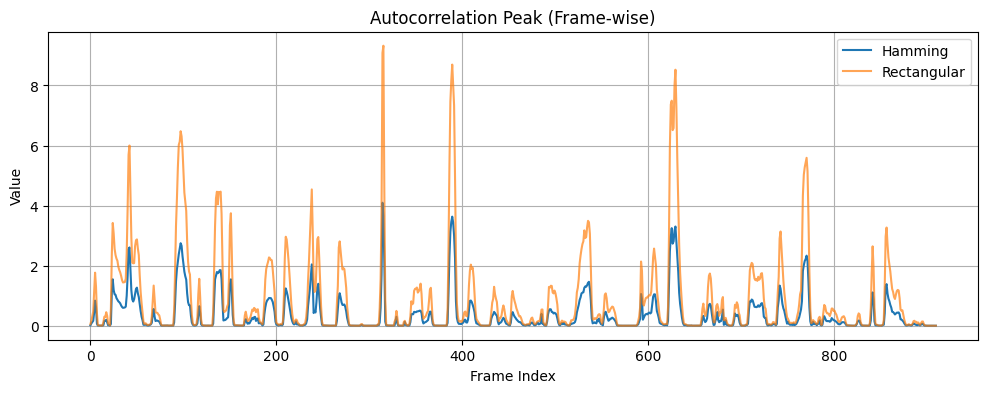

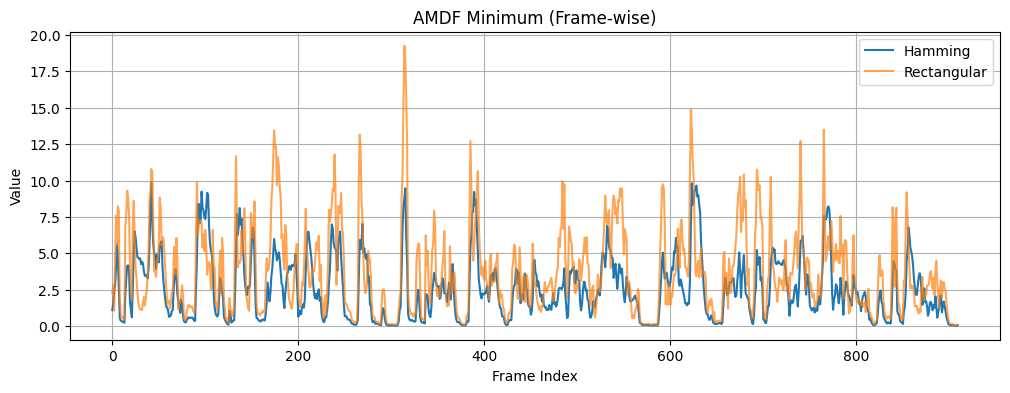

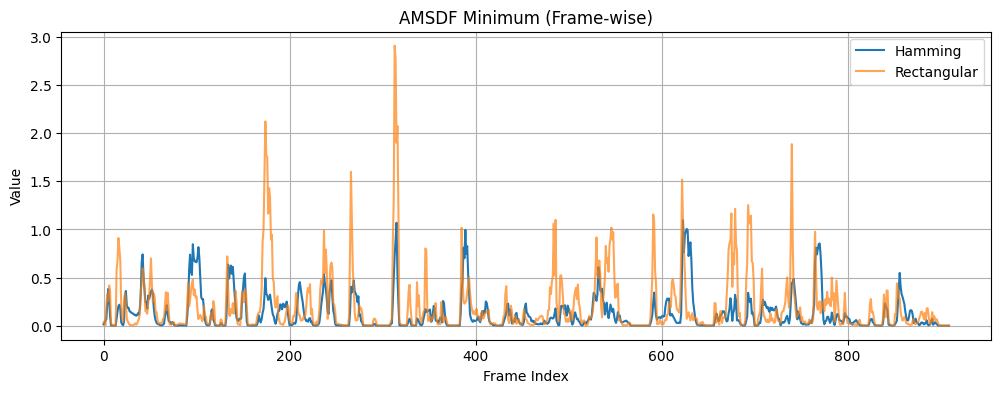

In [3]:

# TASK-1(f) COMPLETION: FRAME-WISE SCALAR PLOTS


# Define lag range again for clarity
min_lag = int(fs / 400)
max_lag = int(fs / 60)

#  ACF: Peak value per frame
acf_peak_h = [np.max(ac[min_lag:max_lag]) for ac in ACF_h]
acf_peak_r = [np.max(ac[min_lag:max_lag]) for ac in ACF_r]

#  AMDF: Minimum value per frame
amdf_min_h = [np.min(d[min_lag:max_lag]) for d in AMDF_h]
amdf_min_r = [np.min(d[min_lag:max_lag]) for d in AMDF_r]

#  AMSDF: Minimum value per frame
amsdf_min_h = [np.min(d[min_lag:max_lag]) for d in AMSDF_h]
amsdf_min_r = [np.min(d[min_lag:max_lag]) for d in AMSDF_r]

#  Plot helper
def plot_compare(y1, y2, title):
    plt.figure(figsize=(12,4))
    plt.plot(y1, label="Hamming")
    plt.plot(y2, label="Rectangular", alpha=0.7)
    plt.title(title + " (Frame-wise)")
    plt.xlabel("Frame Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

#  Plots
plot_compare(acf_peak_h, acf_peak_r, "Autocorrelation Peak")
plot_compare(amdf_min_h, amdf_min_r, "AMDF Minimum")
plot_compare(amsdf_min_h, amsdf_min_r, "AMSDF Minimum")


In [4]:

#task 2c
# FINAL VOICED / UNVOICED CONSENSUS ANALYSIS (OPTIONAL)



voiced_acf_set   = set(voiced_acf)
voiced_amdf_set  = set(voiced_amdf)
voiced_amsdf_set = set(voiced_amsdf)

strongly_voiced = voiced_acf_set
weakly_voiced = (voiced_amdf_set | voiced_amsdf_set) - voiced_acf_set
unvoiced = set(range(num_frames)) - (voiced_amdf_set | voiced_amsdf_set)

print("Strongly Voiced Frames:", len(strongly_voiced))
print("Weakly Voiced Frames:", len(weakly_voiced))
print("Unvoiced Frames:", len(unvoiced))


Strongly Voiced Frames: 695
Weakly Voiced Frames: 202
Unvoiced Frames: 28


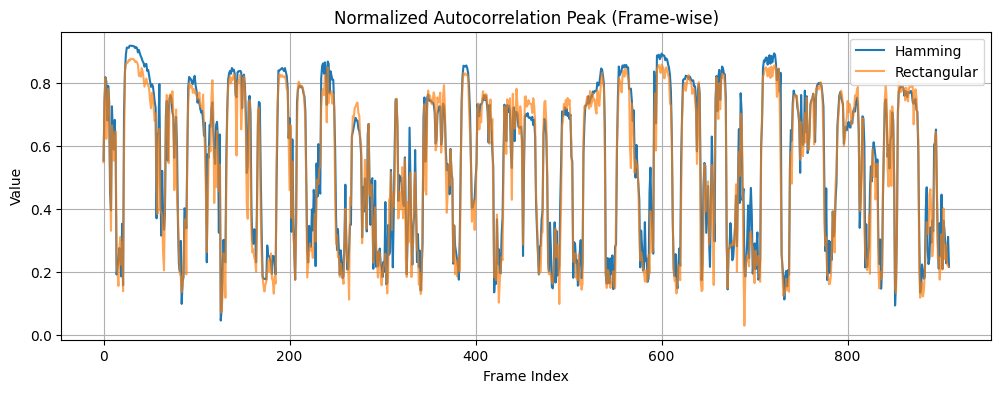

In [5]:
#for 1f
# NORMALIZED ACF PEAK (FRAME-WISE)


acf_peak_h = []
acf_peak_r = []

for ac in ACF_h:
    ac_copy = ac.copy()
    r0 = ac_copy[0]
    ac_copy[0] = 0
    acf_peak_h.append(np.max(ac_copy[min_lag:max_lag]) / r0)

for ac in ACF_r:
    ac_copy = ac.copy()
    r0 = ac_copy[0]
    ac_copy[0] = 0
    acf_peak_r.append(np.max(ac_copy[min_lag:max_lag]) / r0)

plot_compare(acf_peak_h, acf_peak_r, "Normalized Autocorrelation Peak")



In [6]:
#for 3
# PITCH ESTIMATION USING AMDF AND AMSDF (OPTIONAL COMPLETION)


pitch_amdf = []
pitch_amsdf = []

for i in voiced_acf:   # use strongly voiced frames
    # ---- AMDF ----
    d = AMDF_h[i]
    lag_amdf = np.argmin(d[min_lag:max_lag]) + min_lag
    pitch_amdf.append(fs / lag_amdf)

    # ---- AMSDF ----
    d2 = AMSDF_h[i]
    lag_amsdf = np.argmin(d2[min_lag:max_lag]) + min_lag
    pitch_amsdf.append(fs / lag_amsdf)

pitch_amdf = np.array(pitch_amdf)
pitch_amsdf = np.array(pitch_amsdf)

print("Pitch (AMDF) first 5 frames:", pitch_amdf[:5])
print("Pitch (AMSDF) first 5 frames:", pitch_amsdf[:5])


Pitch (AMDF) first 5 frames: [60.37735849 60.37735849 60.37735849 60.37735849 60.37735849]
Pitch (AMSDF) first 5 frames: [ 60.37735849  60.37735849 219.17808219 219.17808219  60.37735849]
